In [1]:
#modules

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import gc

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#random seeds
torch.manual_seed(69)
np.random.seed(69)

In [3]:
#AlexNet

In [4]:
#Data loaders

def get_train_valid_loader(data_dir, batch_size, valid_size = 0.1):
    normalize = transforms.Normalize(
        mean = [0.4914, 0.4822, 0.4465],
        std = [0.2023, 0.1994, 0.2010],
    )
    
    #define transforms
    valid_transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])
    
    train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    
     # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=False, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=False, transform=valid_transform,
    )
    
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [5]:
def get_test_loader(data_dir, batch_size):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=False, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size
    )

    return data_loader

In [ ]:
train_loader, valid_loader = get_train_valid_loader(data_dir = 'C:\DATA\WIDS',
                                                    batch_size = 64,
                                                    valid_size = 0.1
                                                   )

test_loader = get_test_loader(data_dir = 'C:\DATA\WIDS',
                              batch_size = 64)

In [7]:
# ALexNel model

In [8]:
class MyAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyAlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [9]:
# hyper params

In [10]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.005

model = MyAlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)

In [11]:
## training

In [12]:
# Initialize lists to store results
train_loss_list = []
valid_loss_list = []
valid_accuracy_list = []

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        train_loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        gc.collect()
    
    # Store training loss for later visualization
    train_loss_list.append(train_loss.item())

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        valid_loss = 0
        
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            valid_loss += val_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
           
        # Calculate and store validation accuracy and loss
        accuracy = 100 * correct / total
        valid_accuracy_list.append(accuracy)
        valid_loss_list.append(valid_loss / len(valid_loader))  # Average loss per batch
    
 
    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f} %'
          .format(epoch + 1, num_epochs, i + 1, total_step, train_loss.item(), valid_loss / len(valid_loader), accuracy))

In [7]:
#torchvision model
model_ideal = torchvision.models.alexnet(pretrained=True).to(device)

C:\Users\nawka\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nawka\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model_ideal.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model_ideal = model_ideal.to(device)

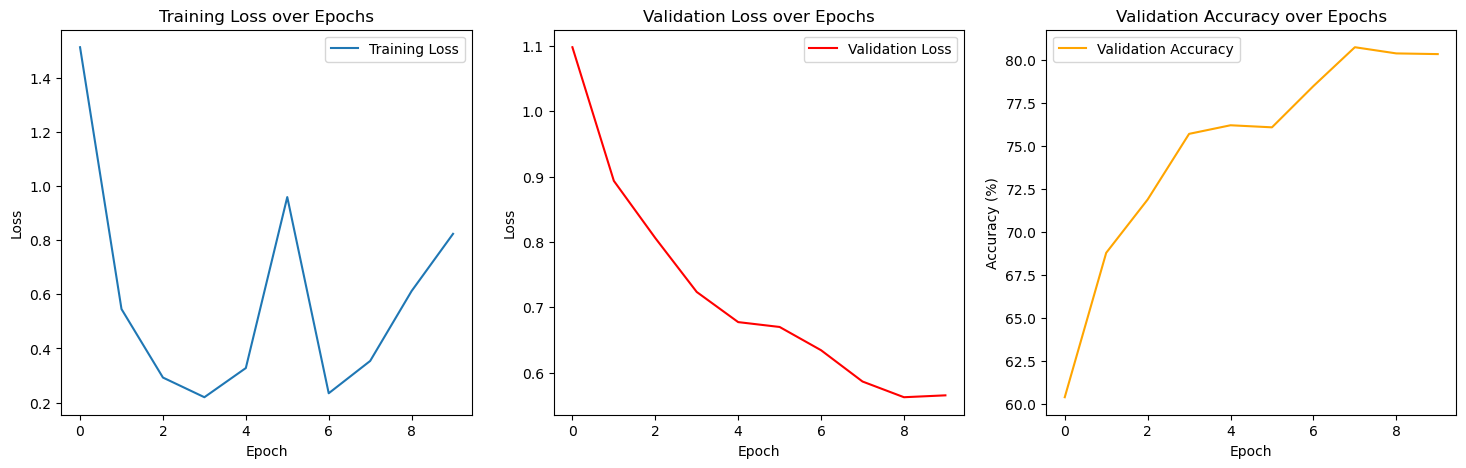

In [14]:
#plots

plt.figure(figsize=(18, 5))

# Plot Training Loss
plt.subplot(2, 3, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Validation Loss
plt.subplot(2, 3, 2)
plt.plot(valid_loss_list, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Plot Validation Accuracy
plt.subplot(2, 3, 3)
plt.plot(valid_accuracy_list, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()            

In [15]:
# testing on MyALexNet model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))  

In [ ]:
#testing on torchvison AlexNet model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ideal(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))  

In [4]:
## model 2: resnet 

In [4]:
#data loaders
def rn_get_train_valid_loader(data_dir, batch_size, valid_size = 0.1):
    normalize = transforms.Normalize(
        mean = [0.4914, 0.4822, 0.4465],
        std = [0.2023, 0.1994, 0.2010],
    )
    
    #define transforms
    valid_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])
    
    train_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])
    
     # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=False, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=False, transform=valid_transform,
    )
    
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [5]:
def rn_get_test_loader(data_dir, batch_size):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=False, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size
    )

    return data_loader

In [6]:
rn_train_loader, rn_valid_loader = rn_get_train_valid_loader(data_dir = 'C:\DATA\WIDS',
                                                    batch_size = 16,
                                                    valid_size = 0.1
                                                   )

rn_test_loader = rn_get_test_loader(data_dir = 'C:\DATA\WIDS',
                              batch_size = 16)

In [7]:
# Resnet Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [13]:
class MyResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(MyResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        # resnet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride = 2)
        
        self.avgpool = nn.AvgPool2d(7, stride = 1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride = 1):
        
        downsample = None
        if stride != 1 or self.inplanes!= planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [14]:
# resnet hyperparams

numclasses = 10
rn_num_epochs = 10
rn_batch_size = 16
rn_lr = 0.01

rn_model = MyResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rn_model.parameters(), lr=rn_lr, weight_decay = 0.001, momentum = 0.9)  


# Train the model
total_step = len(rn_train_loader)

In [15]:
# training
torch.cuda.empty_cache()

In [16]:
# Initialize lists to store results
rn_train_loss_list = []
rn_valid_loss_list = []
rn_valid_accuracy_list = []


In [18]:
for epoch in range(rn_num_epochs):
    for i, (images, labels) in enumerate(rn_train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        print("a" , i , epoch, end = "\r") 
        # Forward pass
        outputs = rn_model(images)
        rn_train_loss = criterion(outputs, labels)
        
        print("b" , i , epoch, end = "\r") 
        # Backward and optimize
        optimizer.zero_grad()
        rn_train_loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        print("c" , i , epoch, end = "\r") 
    # Store training loss for later visualization
    rn_train_loss_list.append(rn_train_loss.item())

            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in rn_valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = rn_model(images)
            rn_val_loss = criterion(outputs, labels)
            rn_val_loss += rn_val_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        # Calculate and store validation accuracy and loss
        accuracy = 100 * correct / total
        rn_valid_accuracy_list.append(accuracy)
        rn_valid_loss_list.append(rn_val_loss / len(rn_valid_loader))  # Average loss per batch
    
    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f} %'
          .format(epoch + 1, rn_num_epochs, i + 1, total_step, rn_train_loss.item(), rn_val_loss / len(rn_valid_loader), accuracy))

Epoch [1/10], Step [2813/2813], Train Loss: 1.1037, Validation Loss: 0.0058, Validation Accuracy: 67.86 %
Epoch [2/10], Step [2813/2813], Train Loss: 1.4871, Validation Loss: 0.0083, Validation Accuracy: 73.44 %
Epoch [3/10], Step [2813/2813], Train Loss: 0.8800, Validation Loss: 0.0025, Validation Accuracy: 77.72 %
Epoch [4/10], Step [2813/2813], Train Loss: 0.3703, Validation Loss: 0.0056, Validation Accuracy: 76.90 %
Epoch [5/10], Step [2813/2813], Train Loss: 0.7005, Validation Loss: 0.0076, Validation Accuracy: 79.76 %
Epoch [6/10], Step [2813/2813], Train Loss: 0.8710, Validation Loss: 0.0021, Validation Accuracy: 80.52 %
Epoch [7/10], Step [2813/2813], Train Loss: 0.2530, Validation Loss: 0.0007, Validation Accuracy: 80.20 %
Epoch [8/10], Step [2813/2813], Train Loss: 0.1950, Validation Loss: 0.0013, Validation Accuracy: 81.04 %
Epoch [9/10], Step [2813/2813], Train Loss: 0.4125, Validation Loss: 0.0019, Validation Accuracy: 81.04 %
Epoch [10/10], Step [2813/2813], Train Loss: 0

In [38]:
#testing MyResNet34
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in rn_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = rn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total)) 

Accuracy of the network on the 10000 test images: 81.35 %


In [37]:
#torchvision ResNet34
rn_model_ideal = torchvision.models.resnet34(pretrained=True).to(device)
rn_model_ideal.fc = nn.Linear(in_features=512, out_features=10, bias=True)
rn_model_ideal = rn_model_ideal.to(device)
rn_model_ideal

C:\Users\nawka\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nawka\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#testing torchvision ResNet34
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in rn_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = rn_model_ideal(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total)) 

In [32]:
#coverting to normal list from tensors list
rn_valid_loss_list = [tensor.cpu() for tensor in rn_valid_loss_list]

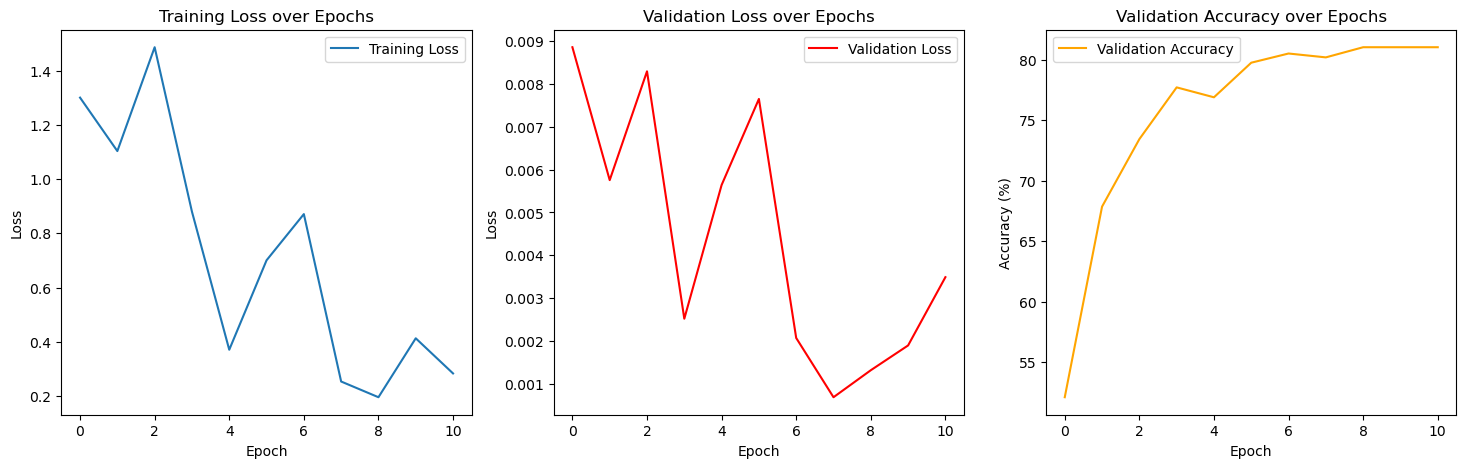

In [33]:
#plots
plt.figure(figsize=(18, 5))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(rn_train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 3, 2)
plt.plot(rn_valid_loss_list, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 3, 3)
plt.plot(rn_valid_accuracy_list, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()              